# Vorticity

## Depth between layers

In [1]:
%run ../_setup.py

import numpy as np

from OceanPy.interpolation import OI

from netCDF4 import Dataset

import matplotlib.pyplot as plt
%matplotlib notebook


In [2]:
# function to determine the depth between layers based on predefined intervals
def layer_depth(sigma0, z, intervals, ref_depth=-10, axis=-1):

    '''
    Layer depth/ thickness as function of interval.
    :param sigma0: density
    :param z: height
    :param interval: list of density intervals
    :return: layer depth and layer thickness
    '''

    if sigma0.shape != z.shape:
        raise ValueError('The shape of sigma0 and z should match, found %s and %s' % (sigma0.shape, z.shape))

    intervals = np.array(intervals)
    if intervals.ndim > 1:
        raise ValueError('The shape of interval should be one-dimensional, found %s' % intervals.ndim)
    if len(intervals) > max(sigma0.shape):
        raise ValueError('The length of interval %s should not exceed the size of sigma0[axis], found %s'
                         % (len(intervals), sigma0.shape[axis]))

    # Number of profiles
    if sigma0.ndim == 1:
        sigma0 = sigma0[np.newaxis, :]
        z = z[np.newaxis, :]

    profiles = sigma0.shape[0]

    depths = np.ones((profiles, len(intervals)))
    for profile in range(profiles):

        for iv, interval in enumerate(intervals):

            # Check if interval limit is within sigma0 limits
            if min(sigma0[profile, ]) < interval < max(sigma0[profile, ]):

                # calculate index of >10 meter reference depth
                # TODO: Ask Helen, 10m reference depth is nedessary and what about mixed layer depth
                i10, ref_dep = min(enumerate(z[profile,]), key=lambda x: abs(x[1] - ref_depth) and x[1] > ref_depth)

                # Search from the minimum error between the observations and the interval limits
                # TODO: Ask Helen, closest value or first value that passes threshold, which threshold then?
                ic, closest = min(enumerate(sigma0[profile, i10:]), key=lambda x: abs(x[1] - interval))
                ic += i10

                # Interpolate sigma0 over the range [-10 : +10] from the minimum error and
                # match the more exact sigma0 with the associated depth(z) value
                depth = np.interp(interval, sigma0[profile, ic - 1:ic + 1], z[profile, ic - 1:ic + 1])
                depths[profile, iv] = depth
            #
            else:
                depths[profile, iv] = np.nan

    return depths, abs(np.diff(depths))

In [4]:
# load adcp and ctd data
input_file = os.path.join(datadir, 'processed', 'ss9802', 'netcdf', 'ss9802_ctd_gsw.nc')
ctd = Dataset(input_file, 'r')

# find indices for pressure levels in CTD prodiles
pressure_levels = {}
for ip, p in enumerate(ctd['p']):
    pressure_levels[p] = ip
    
lon, lat = ctd['lon'][2:, 0], ctd['lat'][2:, 0]
sigma0 = ctd['sigma0'][2:,]
z = -ctd['z'][2:,]


# calculate depth between 2 layers
intervals = np.linspace(26.85, 27.2, 2)

layer_dep, layer_thick = layer_depth(sigma0, z, intervals)
layer_thick = layer_thick.flatten()

# use Optimal Interpolation fuction to interpolate layer depth at ctd locations to grid
xx, yy, ltb, lta = OI(lon, lat, layer_thick, gridsize=(20, 20), Lx=(lon.max() - lon.min())/10)


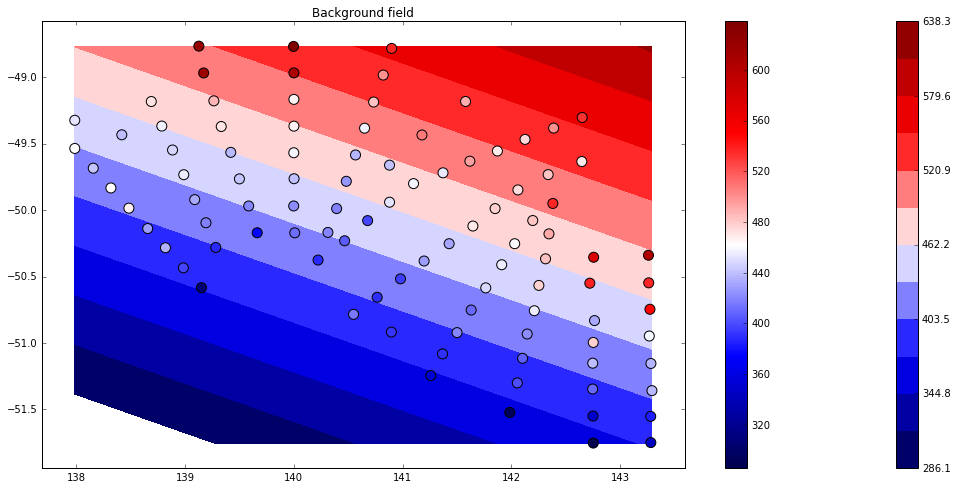

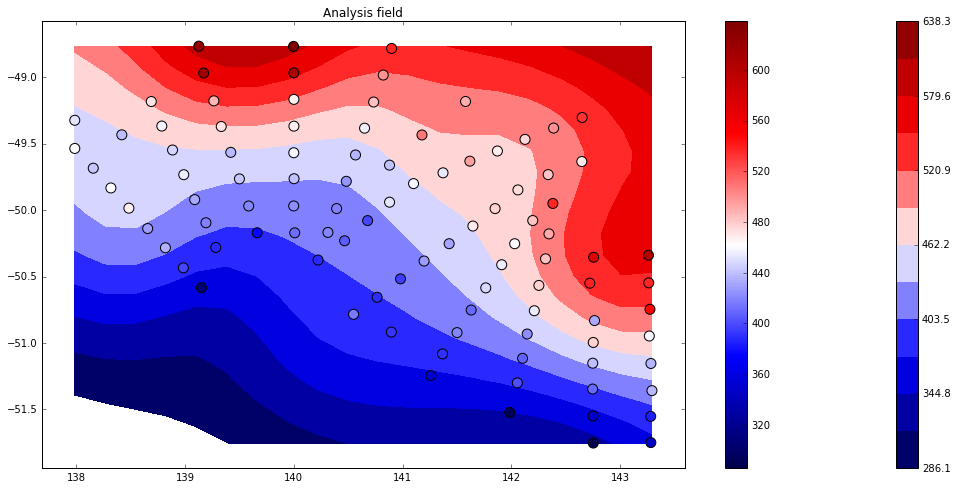

In [5]:
# plot layer depth backgroud field for optimal interpolation
fig, ax = plt.subplots(figsize=(18, 8))
vmin, vmax = layer_thick.min(), layer_thick.max()
cmap = plt.cm.seismic
cf = ax.contourf(xx, yy, ltb, np.linspace(vmin, vmax, 13), cmap=cmap)
plt.colorbar(cf)
scat = plt.scatter(lon, lat, c=layer_thick, s=100, vmin=vmin, vmax=vmax, cmap=cmap)
plt.colorbar(scat)
plt.title('Background field')

# plot layer depth analysis field after optimal interpolation
fig, ax = plt.subplots(figsize=(18, 8))
cf = ax.contourf(xx, yy, lta, np.linspace(vmin, vmax, 13), cmap=cmap)
plt.colorbar(cf)
scat = plt.scatter(lon, lat, c=layer_thick, s=100, vmin=vmin, vmax=vmax, cmap=cmap)
plt.colorbar(scat)
plt.title('Analysis field')


## Planetary vorticty

In [6]:
from gsw import f


In [7]:
coriolis = f(yy)
print(layer_thick.shape)

(99,)


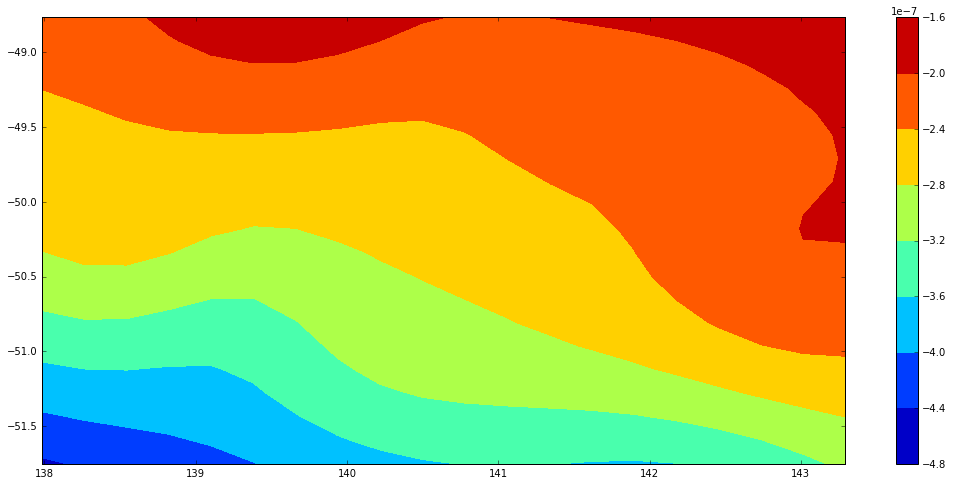

In [10]:
fig, ax = plt.subplots(figsize=(18, 8))
cf = ax.contourf(xx, yy, coriolis/lta)
plt.colorbar(cf)

In [ ]:
input_file = os.path.join(datadir, 'external', 'ssh', 'rep', 'SEALEVEL_GLO_PHY_L4_REP_OBS_137_-52.4_147_-48_199801-199812.nc')
ssh = open_dataset(input_file)